# Flood area Segmentation

Einteilung in Überschwemmungsgebiet (Wasserbereiche auf den Bildern zuverlässig erkennt) - oder nicht.

## Daten
Daten von Kaggle: https://www.kaggle.com/code/faizalkarim/flood-area-segmentation

Datensatz enthält 290 Bilder von überschwemmten Gebieten sowie die dazugehörigen Maskenbilder, die die Wasserflächen markieren. -> Die Masken wurden mit der Open-Source-Software Label Studio erstellt.

### Anwendung des Modells:
Für Überschwemmungsanalysen, bessere Entscheidungen und Planung.

Allerdigns: Aufgrund der geringen Datenmenge sollten vortrainierte Modelle und Datenaugmentation genutzt werden.

### Struktur des Datensatzes:
- Image/: Ordner mit allen Überschwemmungsbildern
- Mask/: Ordner mit den entsprechenden Maskenbildern
- metadata.csv: CSV-Datei, die Bildnamen mit Masken verknüpft

# Modell 1 mit U-Net

## Code
Gefunden auf Kaggle: https://www.kaggle.com/code/ashikshahriar/flood-area-segmentation/notebook

Requirements: GPU (change runtime in this google colab project)

## Laden der Daten und Inspizieren der Daten
https://www.kaggle.com/discussions/general/51898

In [1]:
import os
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")

# access data
base_dir = Path(path)
print('No of images: ', len(os.listdir(base_dir / 'Image')))
print('No of masks: ', len(os.listdir(base_dir / 'Mask')))

/home/aie3/flood-area-segmentation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No of images:  290
No of masks:  290


So sehen die Daten aus - zum Image gibt es die jeweilige Mask (markierte Wasserflächen)

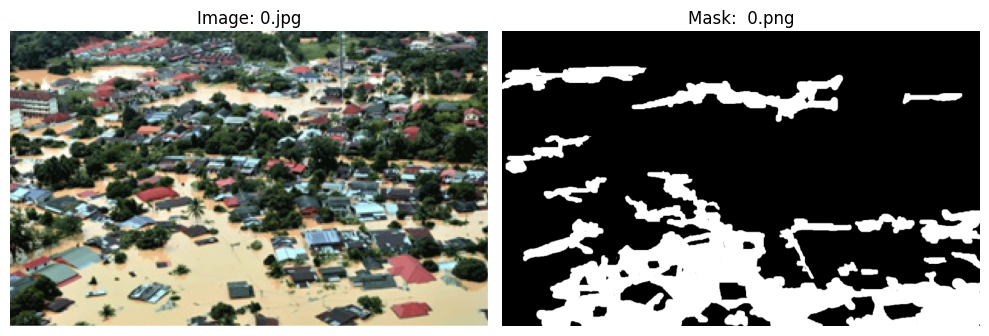

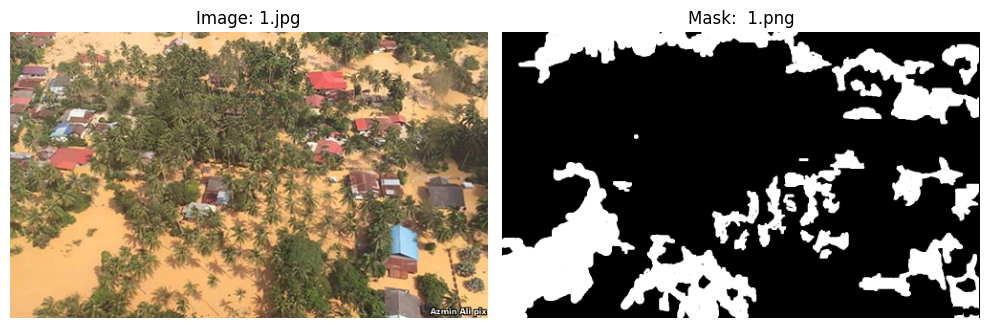

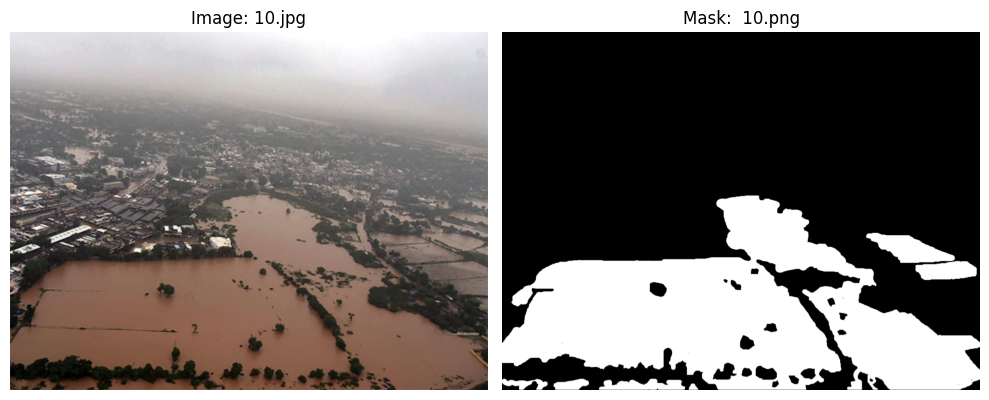

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

image_files = sorted(os.listdir(base_dir / 'Image'))
mask_files = sorted(os.listdir(base_dir / 'Mask'))

for i in range(3):

  image = Image.open(base_dir / 'Image' / image_files[i])
  mask = Image.open(base_dir / 'Mask' / mask_files[i])

  # plot
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.title(f"Image: {image_files[i]}")
  plt.imshow(image)
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.title(f"Mask:  {mask_files[i]}")
  plt.imshow(mask, cmap='gray')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

Maske wird über Bild gelegt - Maskierter Bereich wird jetzt rot dargestellt

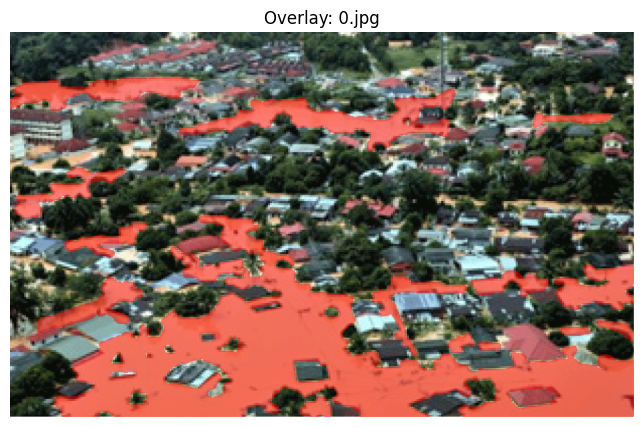

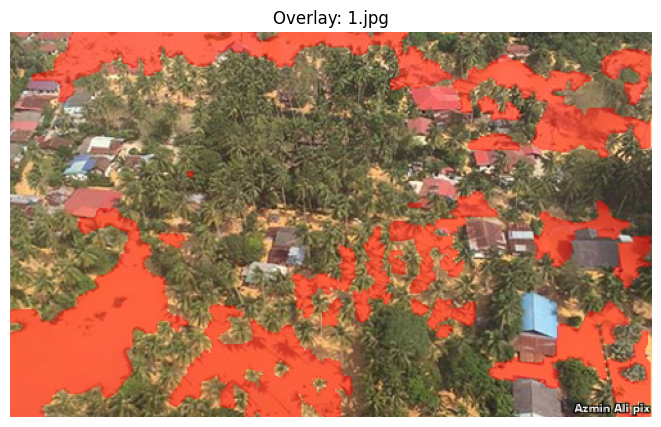

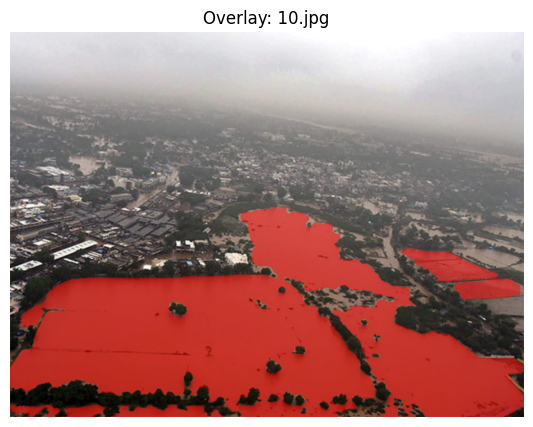

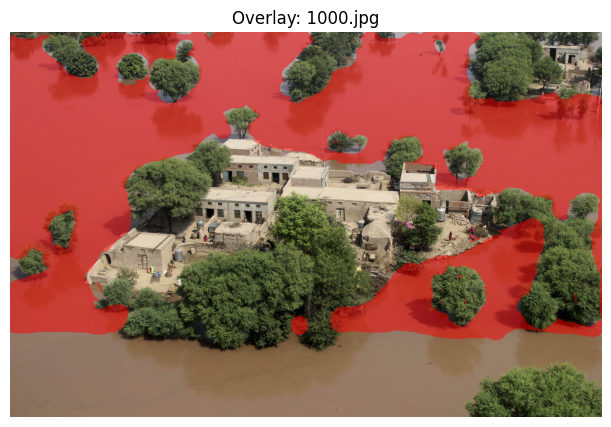

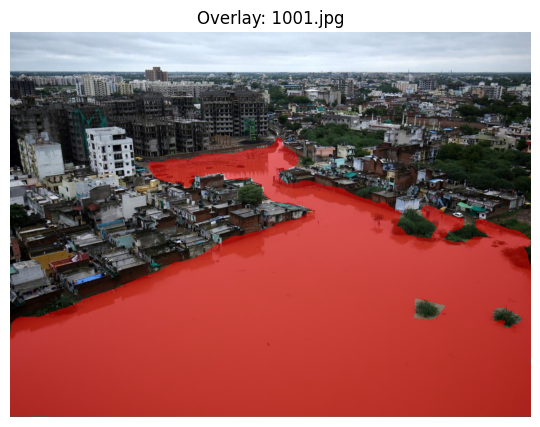

In [3]:
import numpy as np

image_dir = base_dir / 'Image'
mask_dir = base_dir / 'Mask'

def overlay_mask_on_image(num_images=5, alpha=0.5):

    image_files = sorted(os.listdir(image_dir))[:num_images]
    mask_files = sorted(os.listdir(mask_dir))[:num_images]

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        # Convert to numpy arrays
        img_np = np.array(img)
        mask_np = np.array(mask)

        # Create overlay by blending image and mask
        overlay = img_np.copy()
        overlay[mask_np > 0] = [255, 0, 0]  # Highlight mask area in red

        blended = (1 - alpha) * img_np + alpha * overlay
        blended = blended.astype(np.uint8)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.title(f"Overlay: {img_file}")
        plt.imshow(blended)
        plt.axis('off')
        plt.show()

# Call the function
overlay_mask_on_image(num_images=5, alpha=0.5)

## Semantic Segmentation

Ziel ist es, aus Satellitenbildern die Wasserflächen exakt herauszufiltern. Also jedem Pixel die Klasse „Wasser“ oder „kein Wasser“ zuzuweisen.

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

2025-06-08 20:19:39.849214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749413979.865033 3982475 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749413979.869864 3982475 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749413979.882678 3982475 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749413979.882693 3982475 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749413979.882695 3982475 computation_placer.cc:177] computation placer alr

### Datenvorbereitung

Bildergröße (Image und Mask) wird auf 224 x 224 pixel skaliert. Image wird in 3-Kanal-Farbe (RGB) umgewandelt. Mask wird in 1-Kanal Graustufen umgewandelt (Schwarz = 0, Weiß = 255).

Normalisierung: Image und Mask bestehen ursprünglich aus Werten 0–255 (8-Bit). /255 ergibt somit Werte zwischen 0 und 1 == Normalisierung.

Gibt das Array zurück: Listen werden in NumPy-Arrays umgewandlet. Keras erwartet eine zusätzliche axis (axis =1) ... sodass wir die Form (224, 224, 1) erhalten

Batch-size: 32 Bilder werden gleichzeitig beim Training in das NN gegeben



In [5]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

def load_images_and_masks():
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and resize
        img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
        mask = Image.open(mask_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("L")  # Grayscale

        # Normalize image and mask
        images.append(np.array(img) / 255.0)
        masks.append(np.array(mask) / 255.0)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

# Load dataset
images, masks = load_images_and_masks()
print(images.shape)
print(f"Loaded {len(images)} images and masks.")

(290, 224, 224, 3)
Loaded 290 images and masks.


### Auteilung in Train und Validation Daten
20 % Validierung ... 58

80 % Training .. 232

In [6]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
X_train.shape,X_val.shape

((232, 224, 224, 3), (58, 224, 224, 3))

In [7]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Create model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1749413992.198363 3982475 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 76039 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1749413992.200460 3982475 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79183 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:61:00.0, compute capability: 8.0
I0000 00:00:1749413992.201675 3982475 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79183 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:a1:00.0, compute capability: 8.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 56,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 56, 56,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 56, 56,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 112, 112,  │          0 │ conv2d_9[0][0]  

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

### Modelltraining

In [15]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8601 - loss: 0.2691

KeyboardInterrupt: 

### Modell Evaluieren

Loss-Plot: wie gut das Modell im Laufe der Epochen lernt (Trainings- und Validierungsfehler) - zB Overfitting, wenn der Validierungs-Loss steigt, während der Trainings-Loss sinkt.

Accuracy-Plot: wie genau dein Modell bei der Segmentierung ist – sowohl auf den Trainings- als auch Validierungsdaten. Man erkennt, ob das Modell besser wird und wie stabil die Genauigkeit ist.

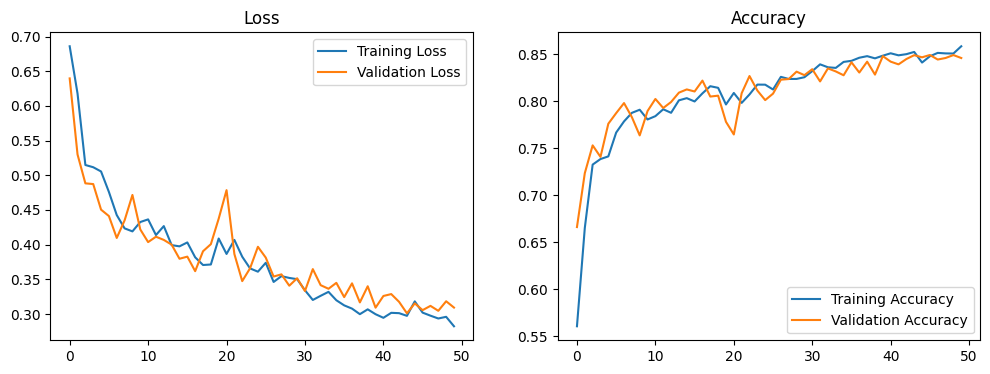

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

Was sagen uns die Plots:

Loss: Training Loss sinkt -> Modell lernt gut; Validation Loss schwankt leicht (denke dass die 58 Bilder nicht wirklich aussagekräftig sind) aber trotzdem Stabil (in der Nähe des Training Loss und kein auseinanderklaffen) -> kein Overfitting -> nach 50 Epochs bei ca 0.3

Accuracy: Trainings- als auch Validierungsgenauigkeit steigen deutlich und stabil und liegen nahe beinander (also verallgemeinert das Modell gut) -> nach 50 Epochs bei ca. 85%

Modell ist präzise und man erkennt kein Under- oder Overfitting

#### Vorhersagen visualisieren

Man sieht das Predicted Mask etwas verschwommen ist -> 85% Accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


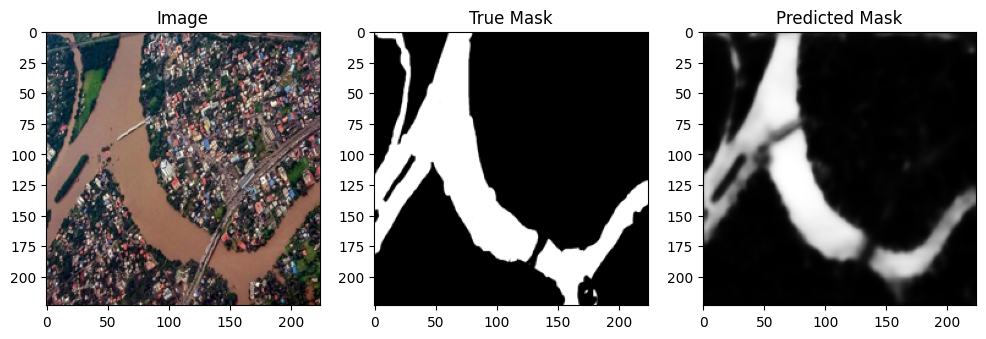

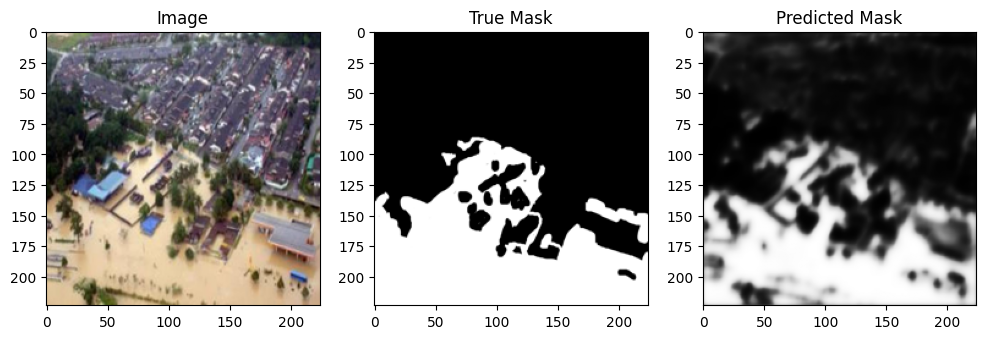

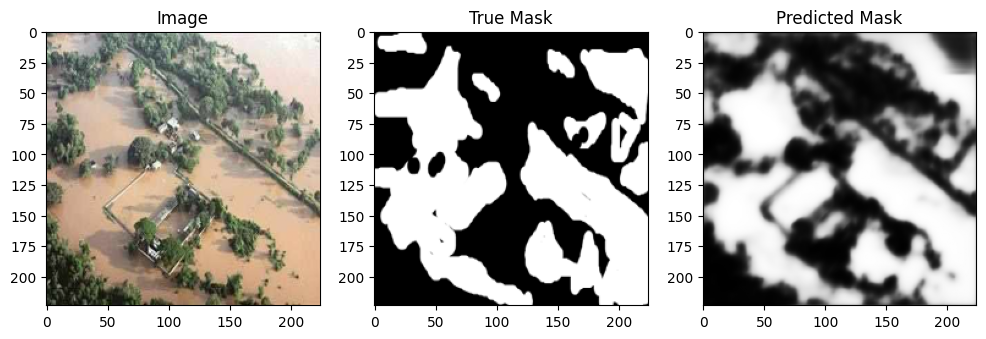

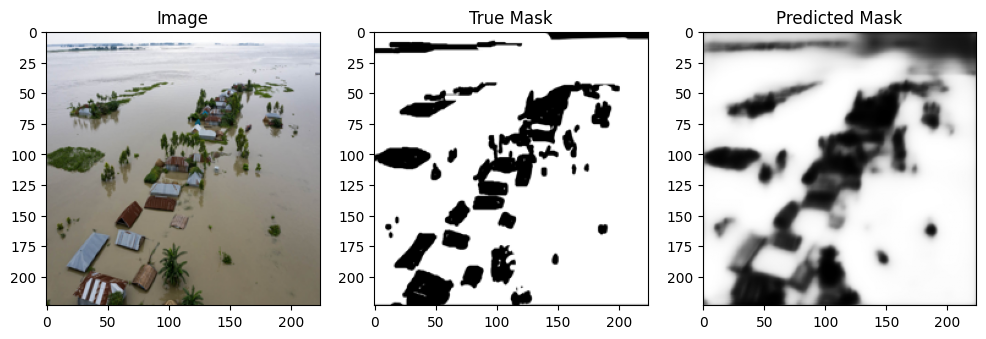

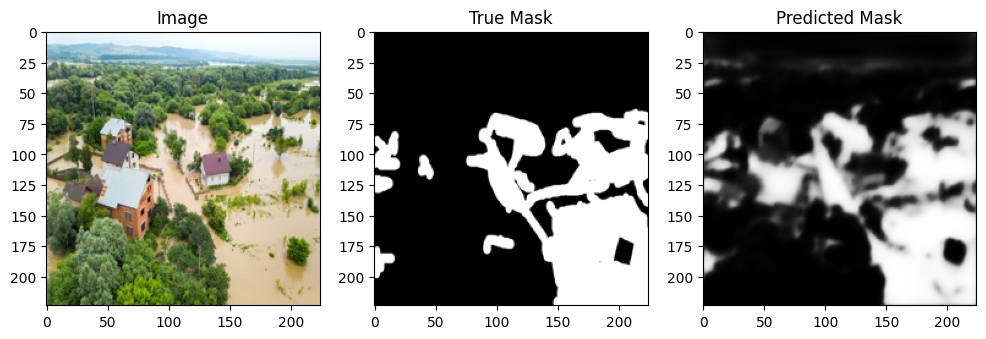

In [10]:
# Visualize predictions
def visualize_predictions(num_images=5):
    preds = model.predict(X_val[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_val[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_val[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')

        plt.show()

visualize_predictions()

## Model speichern

In [13]:
# saves the trained model to the file
model.save('./trained_models/flood_segmentation_model.keras')

### Test
Test ob das gespeicherte Model ist nutzbar

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


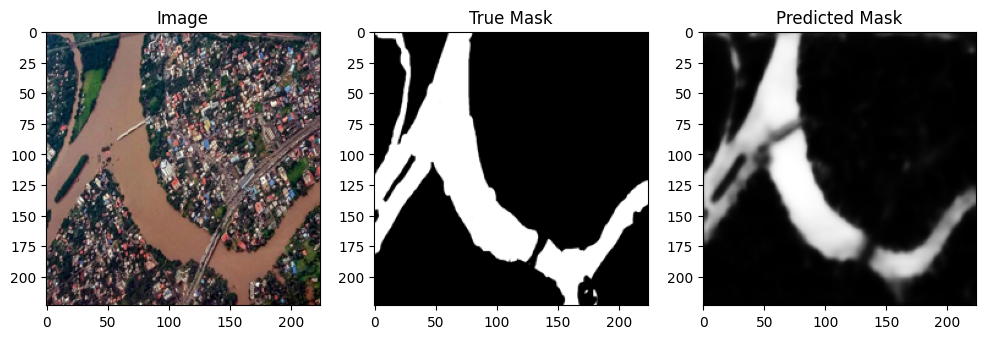

In [14]:
from tensorflow.keras.models import load_model

model = load_model('./trained_models/flood_segmentation_model.keras')
preds = model.predict(X_val[:1])

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(X_val[0])

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(y_val[0].squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(preds[0].squeeze(), cmap='gray')

## U-NET TODO: Performance des Modells weiter verbessern

- [x] Modell speichern - und außerdem noch mehr performance messungen machen - da hab ich in AIE (discord) auch einen link geteilt, der sich mit performance comparence befasst - vielleicht können wir was daraus entnehmen: https://www.kaggle.com/code/subhojeetroy01/flood-prediction-models-performance-comparison
  - Man kann jetzt mit `save_model` das Modell speichern und mit `load_model` laden
  - In `Data_augmentation.ipynb` wurde Intersection over Union (IoU) Metrik implementiert, die gut für Auswertung von Segmentation geeignet ist.   

- [ ] Wie? Anpassen der Parameter/hyperparameter zb
  - Und von diesem code vielleicht noch was übernehmen: https://www.kaggle.com/code/minhbau/flood-area-segmentation-deeplabv3-58f6e1/notebook

- [x] Add data augmentation: https://www.kaggle.com/code/dhaaivat20/unet-from-scratch
  - `Data_augmentation.ipynb`

[`Data_augmentation.ipynb`](https://colab.research.google.com/drive/1bkgYOLEVnUtxBD4WDqfA0yjWMbLgs7az?usp=sharing)


##### Übung 28.05.2025 -> TODOs:

ML-Pipeline: Business Probelm führt zu
- [x] Goal definition
- [x] DataCollection & preparation -> da ist ihnen wichtig dass wir - auch selbst daten labeln
- [x] Feature engineering -> das ist bei cnn nicht wirklich zu machen (bei uns ist data augmentation - gehört aber zu data preparation .... Filter drüberlegen usw machen CNN eh selber) - beispiel
- [x] Model training -> 1 Iteration trainieren und messern reicht nicht (Modell verbessern durch Feature engineering und data collection & preparation ändern (also schaun ob labeling passt) usw) -> auch Nachweis bringen dass Modell mit neuen (also unkenannten) Daten funktioniert (performance halten kann)
- [ ] Model evaluation
- [ ] Model deployment
- [ ] Model serving
- [ ] Model monitoring
- [ ] Model maintenance

Generell:

- Metriken überlegen und auch beschreiben warum sie für Bild Segmentierung gut sind

- auch selbständig Daten labeln (also bei uns die mask)

- ML-Pipeline -> dann für predictions eigene Bilder (google) verwenden und dann schaun ob es trotzdem nocht gut performt -> zb mit overlay von orig bild und predicted mask (dann sieht man zumindest visuell wie das funktioniert)

- Grafiken genererien die Code/Modell zeigen

- was sind unsere Schlüsse daraus

- beim nächsten Termin 10.06.2025 herzeigen, was wir schon gemacht haben

-> workflow
- mit Daten vertraut machen, visualisieren und anschaun
- Modell trainiert und Ergebnisse anschaut - und verbessern 1.Modell Daten anpassen, 2. Modell dann zb Hyperparameter (zb Learning rate) anpassen
- WElche Trainingsstrategien sind notwendig um Modell robust zu machen
- Deployment ist nicht so wichtig (aber ich denk das soll nur theoretisch durchgegangen werden)
- wichtig ist dieser iterativer Prozess -> neue Schichten einfügen, Normalisierung + Lernrate anpassen -> dann auch verstehen was die Änderungen bewirken usw.
- Vergleich von Werten (zb F1 score) mit anderen Arbeiten
- Effekt beschreiben, wenn ich Hyperparameter anpasse

CNN:
Stride = Schritweite bei CNN (also wie Filter angewendet wird) - zero Padding = damit die Größe des inputs gleich bleibt (am Rand werden die zeros hinzugefügt damit schließlich wieder output selbe Größe hat

Wenn man sich die ARchitetur anschaun will von cnn zb
- tensorspace

# Modell 2 mit pretrained YOLO

## Theory
 - Understanding YOLOv8: https://medium.com/@melissa.colin/yolov8-explained-understanding-object-detection-from-scratch-763479652312
 - Slightly more detailed: https://medium.com/@vindyalenawala/yolov8-architecture-a-detailed-overview-5e2c371cf82a
 - Architecture of YOLOv8: https://arxiv.org/html/2408.15857v1#:~:text=The%20architecture%20of%20YOLOv8%20is%20structured%20around,minimize%20computational%20overhead%20while%20retaining%20representational%20power.
 - CSPNet: https://arxiv.org/pdf/1911.11929v1
 - offizielle YOLOv8: https://yolov8.org/yolov8-architecture/

## Flood Area Segmentation mit YOLO und SAM

Wir haben den Code in Kaggle gefunden: https://www.kaggle.com/code/myoungjinson/flood-area-segmentation/notebook#YOLOv8



In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

Daten laden (gleich wie in Modell 1 von Kaggle) und Datensatzprüfung


In [ ]:
import kagglehub
from pathlib import Path

# collect data
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")
base_dir = Path(path)

# create directory structure
for subset in ['train', 'val']:
    os.makedirs(f"dataset/images/{subset}", exist_ok=True)
    os.makedirs(f"dataset/labels/{subset}", exist_ok=True)

# image und mask paths
image_dir = base_dir / "Image"
mask_dir = base_dir / "Mask"

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

img_paths = [image_dir / f for f in image_files]
mask_paths = [mask_dir / f for f in mask_files]

#### Datenvorbereitung

Split in Train und Validation

In [ ]:
import shutil

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    img_paths, mask_paths, test_size=0.2, random_state=42
)

# copy in directories
for img, mask in zip(train_imgs, train_masks):
    shutil.copy(img, f"dataset/images/train/{img.name}")
    shutil.copy(mask, f"dataset/labels/train/{mask.stem}.png")

for img, mask in zip(val_imgs, val_masks):
    shutil.copy(img, f"dataset/images/val/{img.name}")
    shutil.copy(mask, f"dataset/labels/val/{mask.stem}.png")

print("dataset/images/train:", len(os.listdir("dataset/images/train")))
print("dataset/labels/train:", len(os.listdir("dataset/labels/train")))
print("dataset/images/val:  ", len(os.listdir("dataset/images/val")))
print("dataset/labels/val:   ", len(os.listdir("dataset/labels/val")))

Masken müssen wir für YOLO in text files umwandeln

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

example_mask = Image.open("dataset/labels/train/0.png")
plt.imshow(example_mask, cmap='gray')
plt.title("Sample Mask")
plt.axis("off")
plt.show()

In [ ]:
import numpy as np

def mask_to_yolo_txt(mask_path, txt_path, class_id=0):
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        print(f"Failed to read {mask_path}")
        return False

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"No contours found in {mask_path}")
        return False
    h, w = mask.shape

    with open(txt_path, "w") as f:
        for contour in contours:
            if len(contour) < 3:
                continue
            contour = contour.squeeze()
            norm = contour / [w, h]
            norm = norm.flatten()
            norm = ' '.join(map(str, norm))
            f.write(f"{class_id} {norm}\n")

    return True


for subset in ['train', 'val']:
    mask_dir = Path(f"dataset/labels/{subset}")
    for mask_path in mask_dir.glob("*.png"):
        txt_path = mask_path.with_suffix(".txt")  # same folder, same name
        success = mask_to_yolo_txt(mask_path, txt_path)
        if success:
            os.remove(mask_path)  # only remove PNG if txt was created
        else:
            if txt_path.exists():
                os.remove(txt_path)  # remove empty or invalid txt


example_txts = list(Path("dataset/labels/val").glob("*.txt"))
if example_txts:
    print(f"\nSuccessfully created: {example_txts[0]}")
    with open(example_txts[0], "r") as f:
        print("Example content:\n", f.read())
else:
    print("No YOLO label files found.")


print("Train labels:", len(os.listdir("dataset/labels/train")))
print("Val labels:  ", len(os.listdir("dataset/labels/val")))

jetzt ein data.yaml erstellen

In [ ]:
import yaml

data_yaml = {
    'path': 'dataset',                  # root directory
    'train': 'images/train',            # relative to dataset/
    'val': 'images/val',                # relative to dataset/
    'nc': 1,                            # number of classes
    'names': ['flood']                  # list of class names
}

with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

!cat data.yaml

## YOLOv8

https://medium.com/@melissa.colin/yolov8-explained-understanding-object-detection-from-scratch-763479652312

steht für "You Only Look Once" -> für schnelle Inferenzzeiten

wird hier für Segementierung und Objektlokalisierung verwendet -> YOLOv8 ermöglicht Pixel-genaue Masken vorhersagen (vergleichbar mit U-NET, aber zusätzlich mit Objektdetektion)

trainiert wird mit der Library ultralytics; außerdem wird hier ein vortrainiertes Modell geladen und verwendet (verfeinert) -> YOLO("yolo11n-seg.yaml").load("yolo11n.pt")

### Architektur

![U-Net Architektur](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*frzqTxCGA8DHEHMeHug7JQ.png)

#### Backbone – Merkmalsextraktion

Das Backbone extrahiert grundlegende Merkmale wie Kanten, Formen und Texturen aus dem Eingabebild. YOLOv8 verwendet eine modifizierte CSPDarknet53-Architektur, die folgende Techniken kombiniert:

- Convolutional Layers: für Merkmalsextraktion
- Residual Blocks: verhindern den Informationsverlust in tiefen Netzen
- CSPNet (Cross Stage Partial Networks): reduziert Rechenaufwand und verbessert den Gradientendurchfluss
- Darknet53 / CSPDarknet53: als Grundlage des Feature-Backbones

#### Neck – Merkmalsfusion auf mehreren Skalen

Der Neck kombiniert Merkmale unterschiedlicher Auflösung (also unterschiedlicher Conv Layer zB) und verwendet:

- FPN (Feature Pyramid Networks): verarbeitet Bildinformationen auf verschiedenen Skalen
- PANet (Path Aggregation Network): verbessert den Informationsfluss zwischen Ebenen, besonders für kleinere Objekte

Die Feature-Maps (zB P3, P4, P5) werden auf verschiedenen Ebenen zusammengeführt, um die Erkennung von Objekten unterschiedlicher Größe zu ermöglichen.

#### Head – Erkennung & Klassifikation

Der Head erzeugt:

- Bounding Boxes
- Konfidenzwerte
- Klassenvorhersagen



In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n-seg.yaml")  # build a new model from YAML
model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

# Train the model with coco8-seg.yaml
results = model.train(data="data.yaml", epochs=100, imgsz=640, batch=8)

In [ ]:
model.info()

In [ ]:
results

In [ ]:
model.info(verbose=True)

In [ ]:
print(model.model)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.model.to(device)

summary(model.model, input_size=(1, 3, 640, 640), col_names=["input_size", "output_size", "num_params", "trainable"])


Ergebnis - Validation

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 1. load image
val_image_path = "dataset/images/val/1002.jpg"
img = cv2.imread(val_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2. load mask
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")
base_dir = Path(path)
mask_filename = "1002.png"
mask_path = base_dir / "Mask" / mask_filename
mask = Image.open(mask_path).convert("L")
mask = np.array(mask)

# 3. prediction of model
results = model.predict(source=val_image_path, save=False)
pred_mask = results[0].masks.data[0].cpu().numpy()

# 4. plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


# TODO:
Performance messen